<a href="https://www.kaggle.com/code/thanushanth/using-kuhar?scriptVersionId=202093846" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Necessary Imports
import os
import logging
import inspect 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from torch import nn
import torch
import subprocess
from torch.utils.data import Dataset, DataLoader
import math
import time
import seaborn as sns
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import shutil
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix
from sklearn.decomposition import PCA
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns

# Define Constants

In [2]:
LOG_LEVEL = "INFO" # Adjust this to "DEBUG", "INFO", "WARNING" or "ERROR"

activity_id_mapping = {
    0 : "Stand",
    1 : "Sit",
    2 : "Talk-sit",
    3 : "Talk-stand",
    4 : "Stand-sit",
    5 : "Lay",
    6 : "Lay-stand",
    7 : "Pick",
    8 : "Jump",
    9 : "Push-up",
    10 : "Sit-up",
    11 : "Walk",
    12 : "Walk-backward",
    13 : "Walk-circle",
    14 : "Run",
    15 : "Stair-up",
    16 : "Stair-down",
    17 : "Table-tennis"
}

columns = ["activityID", "subjectID", 
               "acc_x", "acc_y", "acc_z", 
               "gyro_x", "gyro_y", "gyro_z", 
               "ori_x", "ori_y", "ori_z"]

EPOCH_BATCH_COUNT = 25
EPOCHS = 100
BATCH_SIZE = 32
IMU_FEATURE_COUNT = 24
CLASSES = 9
LEARNING_RATE = 0.001 # change learning rate 

BEST_ACCURACY = 0.0
BEST_LOSS = 1000

MAX_SAVED_MODELS = 6   # Maximum number of models to keep

# Genarate logs

In [3]:
# Map log level strings to logging constants
log_levels = {
    "DEBUG": logging.DEBUG,
    "INFO": logging.INFO,
    "WARNING": logging.WARNING,
    "ERROR": logging.ERROR
}
set_log_level = log_levels.get(LOG_LEVEL, logging.INFO)  # Default to INFO if an unrecognized level is given

# Configure the logging format and level
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=set_log_level,
    datefmt="%Y-%m-%d %H:%M:%S"
)

def log_message(level, message, block=None, log_title="", caller_frame=None):
    """
    Logs a message with a specific logging level and additional details.
    
    Args:
        level (str): Logging level ('DEBUG', 'INFO', 'WARNING', 'ERROR').
        message (str): The message to log.
        block (str, optional): Additional block/section name for context.
        log_title (str): Title to specify log type.
        caller_frame (frame, optional): Frame object of the calling function.
    """
    # Get the calling function's details for context
    line_number = caller_frame.f_lineno if caller_frame else "N/A"
    function_name = caller_frame.f_code.co_name if caller_frame else "N/A"

    # Format log title and line number to a fixed width
    formatted_title = log_title.ljust(7)  # Pad log title to 7 characters
    formatted_line = f"Line {line_number}".ljust(8)  # Pad line info to 8 characters

    # Format the log with extra details
    # log_msg = f"{formatted_title} | {formatted_line} | {function_name} | {message}"
    log_msg = f"{formatted_title} | {formatted_line} | {message}"
    if block:
        log_msg += f" - Block: {block}"

    # Check if the log level should print based on the configured log level
    should_print = log_levels[level.upper()] >= set_log_level

    if should_print:
        print(log_msg)  # Print the message if it meets or exceeds the log level

    # Log the message based on the specified level
    if level.upper() == "DEBUG":
        logging.debug(log_msg)
    elif level.upper() == "INFO":
        logging.info(log_msg)
    elif level.upper() == "WARNING":
        logging.warning(log_msg)
    elif level.upper() == "ERROR":
        logging.error(log_msg)
    else:
        logging.info("Unknown log level specified.")

# Shortcut functions for different levels
def print_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("INFO", message, block, log_title="INFO", caller_frame=caller_frame)

def debug_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("DEBUG", message, block, log_title="DEBUG", caller_frame=caller_frame)

def warn_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("WARNING", message, block, log_title="WARNING", caller_frame=caller_frame)

def error_log(message, block=None):
    caller_frame = inspect.currentframe().f_back
    log_message("ERROR", message, block, log_title="ERROR", caller_frame=caller_frame)

In [4]:
# The example usage of logs
print_log("Training started", block="Training Phase")
debug_log("Loaded 500 records", block="Data Loading")
warn_log("Missing values detected", block="Data Validation")
error_log("Failed to save model", block="Model Saving")

INFO    | Line 2   | Training started - Block: Training Phase
WARNING | Line 4   | Missing values detected - Block: Data Validation
ERROR   | Line 5   | Failed to save model - Block: Model Saving


# Clear Working Directory

In [5]:
import os
import shutil


def clear_working_directory():
    # Define the directory to clear
    directory_to_clear = '/kaggle/working/'

    # Iterate through all files and directories in the specified directory
    for filename in os.listdir(directory_to_clear):
        file_path = os.path.join(directory_to_clear, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
            print_log(f"Removed: {file_path}")  # Optional: Print the removed file or directory
        except Exception as e:
            error_log(f"Failed to remove {file_path}. Reason: {e}")


In [6]:
clear_working_directory()

INFO    | Line 17  | Removed: /kaggle/working/__notebook__.ipynb


# Preprocessing Data

In [7]:
#Reading data:

df = pd.read_csv("/kaggle/input/kuhar/3.Time_domain_subsamples/KU-HAR_time_domain_subsamples_20750x300.csv",header=None)
dff = df.values
signals = dff[:, 0: 1800] #These are the time-domian subsamples (signals) 
signals = np.array(signals, dtype=np.float32)
labels = dff[:, 1800] #These are their associated class labels (signals)

print_log(f"signals shape: {signals.shape} and labels shape: {labels.shape}")


INFO    | Line 9   | signals shape: (20750, 1800) and labels shape: (20750,)


In [8]:
# Reshape signals into 300 samples per axis for each sensor type (acc, gyro, orientation)
# For accelerometer data (X, Y, Z axis)
acc_x = signals[:, :300]
acc_y = signals[:, 300:600]
acc_z = signals[:, 600:900]
gyro_x = signals[:, 900:1200]
gyro_y = signals[:, 1200:1500]
gyro_z = signals[:, 1500:1800]

# Create a list to hold all rows of data
data_rows = []

# Loop over each activity ID and create rows for each sample and axis
for i in range(len(labels)):
    activity_id = labels[i]
    
    # For each of the 300 samples, create a row with each sensor axis value
    for sample in range(300):
        data_rows.append({"activityID": int(activity_id), 
                          "acc_x": acc_x[i, sample],
                         "acc_y" : acc_y[i, sample],
                         "acc_z" : acc_z[i, sample],
                         "gyro_x" : gyro_x[i, sample],
                         "gyro_y" : gyro_y[i, sample],
                         "gyro_z" : gyro_z[i, sample]})

# Create a DataFrame from the expanded data
new_df = pd.DataFrame(data_rows)
print_log("The basic new dataframe is genarated")
new_df

INFO    | Line 29  | The basic new dataframe is genarated


,activityID,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,0,0.004231,0.005034,-0.020325,-0.000043,0.012474,-0.000880
1,0,-0.000280,0.011153,-0.022526,-0.000816,0.010088,-0.001606
2,0,-0.013906,0.029063,-0.020546,-0.002955,0.001830,-0.001985
3,0,-0.002544,0.037302,-0.001819,-0.005451,0.005573,-0.000610
4,0,0.027433,0.045905,-0.004089,-0.007748,0.006235,-0.001509
...,...,...,...,...,...,...,...
6224995,9,-1.107400,0.399240,-0.074573,0.192290,0.531560,0.004095
6224996,9,-1.902100,-1.091000,-1.568400,0.225660,0.550410,0.006755
6224997,9,-1.444000,-0.572160,-0.921060,0.289010,0.586970,0.013448
6224998,9,-0.383910,-0.559630,0.385480,0.284010,0.591070,0.027566


# **Standardize the dataframe** 
Standardize the record count across all activities for each subject.

In [9]:
activity_counts = new_df.groupby('activityID').size()

# Print the counts for each activityID
print(activity_counts)

activityID
0     565800
1     562200
2     539100
3     559800
4     653400
5     543900
6     528600
7     399900
8     199800
9     144000
10    301500
11    264600
12     95100
13     77700
14    178500
15    239400
16    234300
17    137400
dtype: int64


In [10]:
# # Count the number of records for each activityID
# activity_counts = new_df.groupby('activityID').size()

# # Find the minimum count of records
# min_records = activity_counts.min()

# # Print the minimum count and the corresponding activityID(s)
# min_activity_ids = activity_counts[activity_counts == min_records].index.tolist()

# print_log(f"Minimum number of records: {min_records}")
# print_log(f"Activity IDs with minimum records: {min_activity_ids}")


In [11]:
# # Count the number of records for each activityID
# activity_counts = new_df.groupby('activityID').size()

# # Find the minimum count of records
# min_records = activity_counts.min()

# # Initialize a list to store the resampled DataFrames
# equalized_dfs = []

# # Iterate through each activityID
# for activity_id in activity_counts.index:
#     # Filter the DataFrame for the current activityID
#     activity_data = new_df[new_df['activityID'] == activity_id]
    
#     # Resample the data to the minimum count with replacement
#     resampled_data = activity_data.sample(n=min_records, replace=True, random_state=42)
    
#     # Append the resampled DataFrame to the list
#     equalized_dfs.append(resampled_data)

# # Concatenate all resampled DataFrames into one
# equalized_df = pd.concat(equalized_dfs, ignore_index=True)
# print_log("The dataframe is Standardized")

# # Show the final equalized DataFrame
# print(equalized_df.groupby('activityID').size())  # Check the counts per activityID

# # Reassign the dataframe
# new_df = equalized_df
# new_df

In [12]:
new_df

,activityID,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,0,0.004231,0.005034,-0.020325,-0.000043,0.012474,-0.000880
1,0,-0.000280,0.011153,-0.022526,-0.000816,0.010088,-0.001606
2,0,-0.013906,0.029063,-0.020546,-0.002955,0.001830,-0.001985
3,0,-0.002544,0.037302,-0.001819,-0.005451,0.005573,-0.000610
4,0,0.027433,0.045905,-0.004089,-0.007748,0.006235,-0.001509
...,...,...,...,...,...,...,...
6224995,9,-1.107400,0.399240,-0.074573,0.192290,0.531560,0.004095
6224996,9,-1.902100,-1.091000,-1.568400,0.225660,0.550410,0.006755
6224997,9,-1.444000,-0.572160,-0.921060,0.289010,0.586970,0.013448
6224998,9,-0.383910,-0.559630,0.385480,0.284010,0.591070,0.027566


# Visualize

In [13]:
def visualize_activity_data(activity_id, df):
    # Filter data for the specific activity ID
    activity_data = df[df['activityID'] == activity_id]
    
    # Ensure there are enough samples for plotting (300 samples)
    if len(activity_data) < 300:
        warn_log(f"Not enough samples for activity ID {activity_id}")
        return
    
    # Extract sensor data for the first 300 samples for each axis
    acc_x = activity_data['acc_x'].values[:300]
    acc_y = activity_data['acc_y'].values[:300]
    acc_z = activity_data['acc_z'].values[:300]
    gyro_x = activity_data['gyro_x'].values[:300]
    gyro_y = activity_data['gyro_y'].values[:300]
    gyro_z = activity_data['gyro_z'].values[:300]
    
    # Generate time array (assuming each sample is 0.01 seconds apart)
    time = np.linspace(0.01, 3, 300)
    
    # Create subplots
    plt.figure(figsize=(10, 18))
    
    # Plot accelerometer X axis
    ax1 = plt.subplot(611)
    ax1.plot(time, acc_x, color='b')
    ax1.title.set_text('Accelerometer X axis')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Acceleration (m/s^2)')
    ax1.grid(True)
    print_log("Accelerometer X axis plot is created")
    
    # Plot accelerometer Y axis
    ax2 = plt.subplot(612)
    ax2.plot(time, acc_y, color='g')
    ax2.title.set_text('Accelerometer Y axis')
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('Acceleration (m/s^2)')
    ax2.grid(True)
    print_log("Accelerometer Y axis plot is created")
    
    # Plot accelerometer Z axis
    ax3 = plt.subplot(613)
    ax3.plot(time, acc_z, color='r')
    ax3.title.set_text('Accelerometer Z axis')
    ax3.set_xlabel('time (s)')
    ax3.set_ylabel('Acceleration (m/s^2)')
    ax3.grid(True)
    print_log("Accelerometer Z axis plot is created")
    
    # Plot gyroscope X axis
    ax4 = plt.subplot(614)
    ax4.plot(time, gyro_x, color='b')
    ax4.title.set_text('Gyroscope X axis')
    ax4.set_xlabel('time (s)')
    ax4.set_ylabel('Angular rotation (rad/s)')
    ax4.grid(True)
    print_log("Gyroscope X axis plot is created")
    
    # Plot gyroscope Y axis
    ax5 = plt.subplot(615)
    ax5.plot(time, gyro_y, color='g')
    ax5.title.set_text('Gyroscope Y axis')
    ax5.set_xlabel('time (s)')
    ax5.set_ylabel('Angular rotation (rad/s)')
    ax5.grid(True)
    print_log("Gyroscope Y axis plot is created")
    
    # Plot gyroscope Z axis
    ax6 = plt.subplot(616)
    ax6.plot(time, gyro_z, color='r')
    ax6.title.set_text('Gyroscope Z axis')
    ax6.set_xlabel('time (s)')
    ax6.set_ylabel('Angular rotation (rad/s)')
    ax6.grid(True)
    print_log("Gyroscope Z axis plot is created")
    
    # Show the plot
    plt.tight_layout()
    plt.show()




INFO    | Line 31  | Accelerometer X axis plot is created
INFO    | Line 40  | Accelerometer Y axis plot is created
INFO    | Line 49  | Accelerometer Z axis plot is created
INFO    | Line 58  | Gyroscope X axis plot is created
INFO    | Line 67  | Gyroscope Y axis plot is created
INFO    | Line 76  | Gyroscope Z axis plot is created


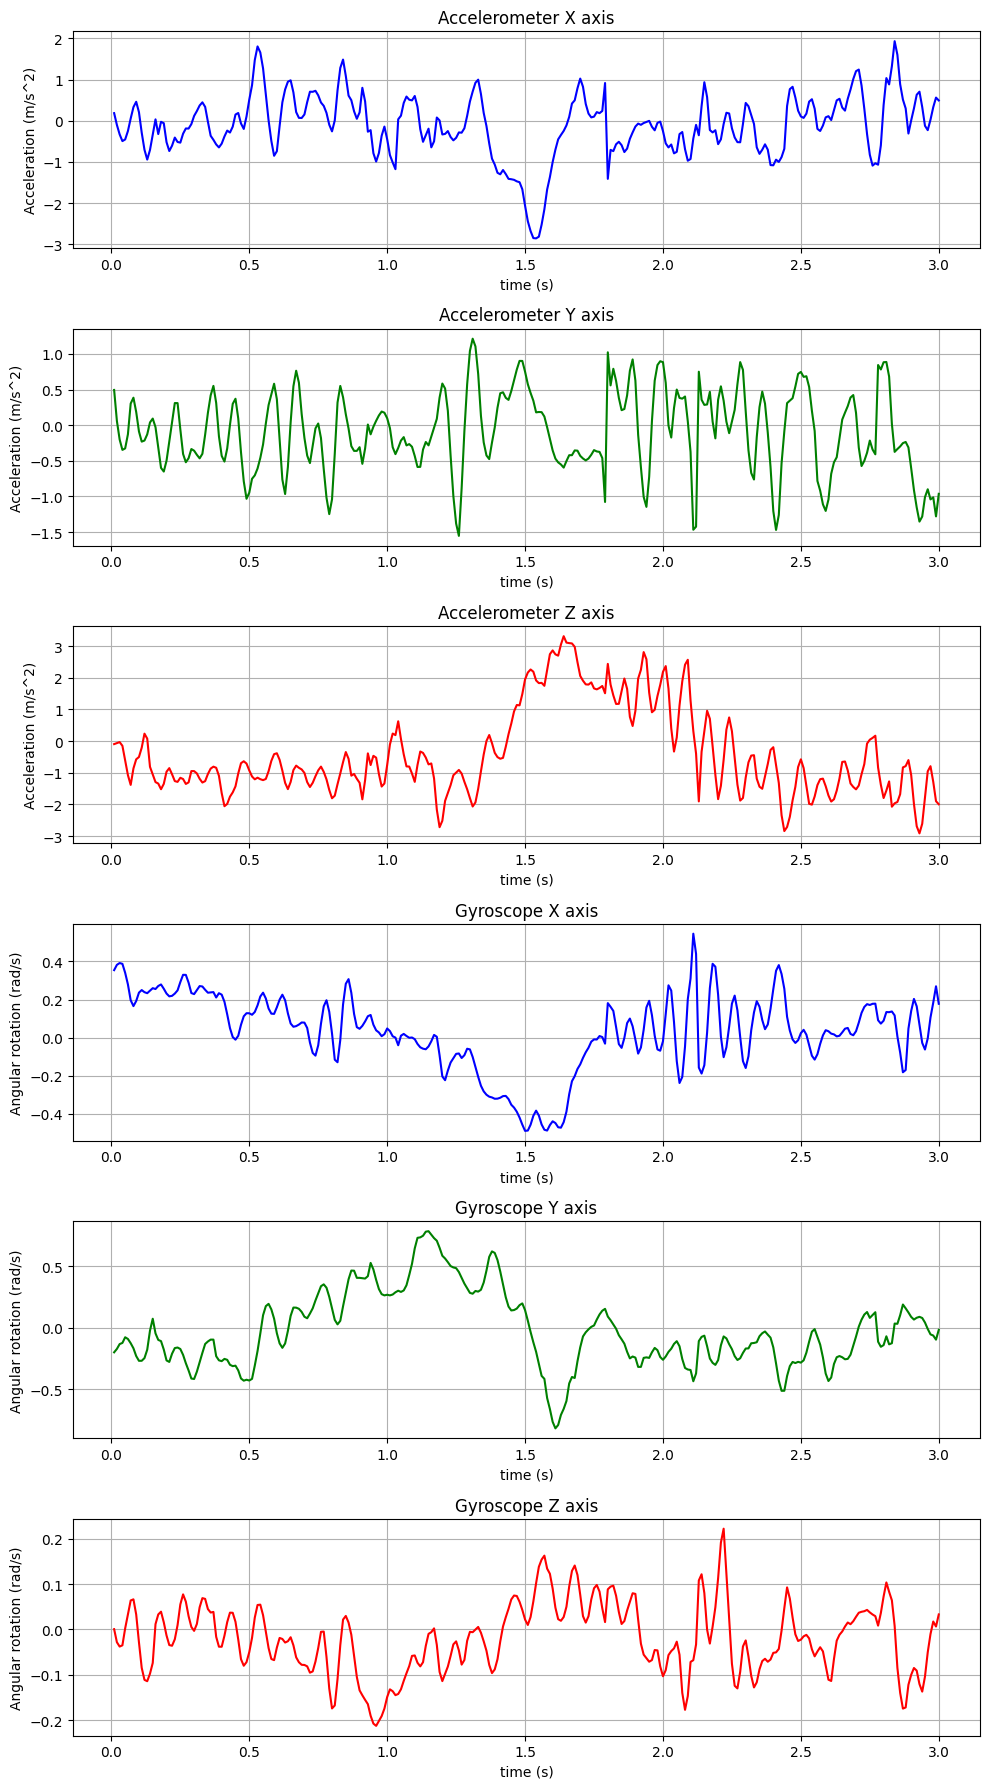

In [14]:
visualize_activity_data(activity_id=9, df=new_df)

# Transform the data

In [15]:
# Function to create a DataFrame with original values, derivatives, and Fourier transforms
def create_transformed_df(df):
    transformed_data = {}

    # Include original values for each column, including activityID
    transformed_data['activityID'] = df['activityID']
    for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
        transformed_data[col] = df[col]  # Add original data

        # Compute first derivative
        transformed_data[f'{col}_fd'] = np.gradient(df[col])
        
        # Compute second derivative
        transformed_data[f'{col}_sd'] = np.gradient(transformed_data[f'{col}_fd'])
        
        # Compute Fourier Transform (absolute values to keep real magnitudes)
        transformed_data[f'{col}_fourier'] = np.abs(np.fft.fft(df[col]))

    # Create the final DataFrame
    transformed_df = pd.DataFrame(transformed_data)
    print_log("The first and secind derivatives, and Fourier transforms values of sensor data added in the dataframe")

    return transformed_df


In [16]:
def assign_subject_ids(df):
    # Get unique activity IDs in the dataset
    activity_ids = df['activityID'].unique()
    
    # Initialize list to hold subject IDs
    subject_ids = []
    
    # Loop over each activity ID
    for activity_id in activity_ids:
        # Get subset for the specific activity
        activity_df = df[df['activityID'] == activity_id]
        
        # Calculate the number of records per subject for the activity
        records_per_subject = len(activity_df) // 10
        
        # Create subject IDs (1 to 10) for each partition of the activity
        subject_id_repeated = np.repeat(np.arange(1, 11), records_per_subject)
        
        # Handle any leftover rows if records are not perfectly divisible by 10
        remaining = len(activity_df) - len(subject_id_repeated)
        subject_id_repeated = np.concatenate([subject_id_repeated, np.arange(1, remaining + 1)])
        
        # Append these subject IDs to the list
        subject_ids.extend(subject_id_repeated)
    
    # Add subjectID to the DataFrame
    df['subjectID'] = subject_ids
    print_log("subjectID is assign for every record")
    return df



In [17]:
# cretae transformed df it include first and second derivative and fourior, Assign the subject IDs from 0 to 10
transformed_df = create_transformed_df(new_df)
final_df = assign_subject_ids(transformed_df)
final_df

INFO    | Line 21  | The first and secind derivatives, and Fourier transforms values of sensor data added in the dataframe
INFO    | Line 28  | subjectID is assign for every record


,activityID,acc_x,acc_x_fd,acc_x_sd,acc_x_fourier,acc_y,acc_y_fd,acc_y_sd,acc_y_fourier,acc_z,...,gyro_x_fourier,gyro_y,gyro_y_fd,gyro_y_sd,gyro_y_fourier,gyro_z,gyro_z_fd,gyro_z_sd,gyro_z_fourier,subjectID
0,0,0.004231,-0.004511,-0.004557,3.409929e+08,0.005034,0.006119,0.005895,7.941640e+08,-0.020325,...,3.067206e+06,0.012474,-0.002386,-0.002936,4.702947e+08,-0.000880,-0.000726,0.000174,8.738595e+08,1
1,0,-0.000280,-0.009068,0.001690,3.419450e+08,0.011153,0.012015,0.003478,7.940186e+08,-0.022526,...,3.117677e+06,0.010088,-0.005322,0.000064,4.702819e+08,-0.001606,-0.000553,0.000612,8.737983e+08,1
2,0,-0.013906,-0.001132,0.014869,3.443061e+08,0.029063,0.013074,-0.001797,7.932826e+08,-0.020546,...,3.287769e+06,0.001830,-0.002258,0.003762,4.702521e+08,-0.001985,0.000498,0.000395,8.735901e+08,1
3,0,-0.002544,0.020670,0.015777,3.480081e+08,0.037302,0.008421,-0.006358,7.919042e+08,-0.001819,...,3.589566e+06,0.005573,0.002203,0.001694,4.701781e+08,-0.000610,0.000238,-0.001317,8.733036e+08,1
4,0,0.027433,0.030422,-0.004276,3.536309e+08,0.045905,0.000359,-0.009117,7.899923e+08,-0.004089,...,3.943388e+06,0.006235,0.001131,-0.001527,4.700879e+08,-0.001509,-0.002137,-0.001183,8.728075e+08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224995,9,-1.107400,-0.330150,-0.144375,3.603005e+08,0.399240,-1.069550,-0.241177,7.876171e+08,-0.074573,...,4.461135e+06,0.531560,0.037025,-0.017020,4.699568e+08,0.004095,-0.056183,0.066720,8.722616e+08,10
6224996,9,-1.902100,-0.168300,0.544622,3.536309e+08,-1.091000,-0.485700,0.667617,7.899923e+08,-1.568400,...,3.943388e+06,0.550410,0.027705,-0.008347,4.700879e+08,0.006755,0.004677,0.033294,8.728075e+08,10
6224997,9,-1.444000,0.759095,0.255820,3.480081e+08,-0.572160,0.265685,0.246945,7.919042e+08,-0.921060,...,3.589566e+06,0.586970,0.020330,-0.016537,4.701781e+08,0.013448,0.010406,0.029427,8.733036e+08,10
6224998,9,-0.383910,0.343340,-0.566252,3.443061e+08,-0.559630,0.008190,-0.130918,7.932826e+08,0.385480,...,3.287769e+06,0.591070,-0.005370,-0.017585,4.702521e+08,0.027566,0.063531,0.051269,8.735901e+08,10


In [18]:
def split_data(df, train_ratio=0.7, test_ratio=0.2, validation_ratio=0.1):
    # Initialize empty DataFrames for train, test, and validation
    train_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)
    validation_df = pd.DataFrame(columns=df.columns)

    # Iterate over each group of (activityID, subjectID)
    for (activity_id, subject_id), group in df.groupby(['activityID', 'subjectID']):
        n = len(group)
        train_end = int(train_ratio * n)
        test_end = train_end + int(test_ratio * n)
        
        # Split into train, test, validation based on indices
        train_data = group.iloc[:train_end]
        test_data = group.iloc[train_end:test_end]
        validation_data = group.iloc[test_end:]
        
        # Concatenate only if the DataFrames are not empty and have valid data
        if not train_data.empty and not train_data.isna().all().any():
            train_df = pd.concat([train_df, train_data], ignore_index=True)
        if not test_data.empty and not test_data.isna().all().any():
            test_df = pd.concat([test_df, test_data], ignore_index=True)
        if not validation_data.empty and not validation_data.isna().all().any():
            validation_df = pd.concat([validation_df, validation_data], ignore_index=True)
    
    print_log("Data is splited in 3 part such as tran, test and validation")

    return train_df, test_df, validation_df


In [19]:
train_df, test_df, validation_df = split_data(final_df)

print_log(f"Train data shape : {train_df.shape}")
print_log(f"Test data shape: {test_df.shape}")
print_log(f"Validation data shape: {validation_df.shape}")

# # Define the file paths for saving the CSV files
# train_csv_path = '/kaggle/working/train_data.csv'
# test_csv_path = '/kaggle/working/test_data.csv'
# validation_csv_path = '/kaggle/working/validation_data.csv'

# # Save the DataFrames to CSV files
# train_df.to_csv(train_csv_path, index=False)
# print_log("train_data.csv file is created")
# test_df.to_csv(test_csv_path, index=False)
# print_log("test_data.csv file is created")
# validation_df.to_csv(validation_csv_path, index=False)
# print_log("validation_data.csv file is created")

/tmp/ipykernel_24/1035667665.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, train_data], ignore_index=True)
/tmp/ipykernel_24/1035667665.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, test_data], ignore_index=True)
/tmp/ipykernel_24/1035667665.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns whe

INFO    | Line 26  | Data is splited in 3 part such as tran, test and validation
INFO    | Line 3   | Train data shape : (4357496, 26)
INFO    | Line 4   | Test data shape: (1245000, 26)
INFO    | Line 5   | Validation data shape: (622504, 26)


In [20]:
train_df.groupby(['activityID', 'subjectID']).size()

activityID  subjectID
0           1            39606
            2            39606
            3            39606
            4            39606
            5            39606
                         ...  
17          4             4326
            7             4094
            8            12495
            9            12495
            10           12495
Length: 156, dtype: int64

In [21]:
def generate_sequence_list(df, sequence_length=500, overlap=20):
    # Initialize the main list to hold all sequences for all activities
    imu_data_sequence = []

    # Group by activityID to handle each activity separately
    grouped_by_activity = df.groupby('activityID')

    # Iterate over each activity group
    for activity_id, activity_group in grouped_by_activity:
        # Initialize a list for this activity
        activity_data_sequence = []

        # Group by subjectID within the activity group
        grouped_by_subject = activity_group.groupby('subjectID')
        
        # Iterate over each subject group within the activity
        for subject_id, subject_group in grouped_by_subject:
            # Extract the data values excluding activityID and subjectID
            data_values = subject_group.drop(columns=['activityID', 'subjectID']).values
            
            # Calculate the number of sequences
            num_samples = len(data_values)
            num_sequences = (num_samples - sequence_length) // overlap + 1
            
            # Create a list for this subject's sequences
            subject_sequences = []
            
            # Generate sequences for this subject
            for i in range(num_sequences):
                sequence_start = i * overlap
                sequence_end = sequence_start + sequence_length
                if sequence_end <= num_samples:
                    # Append the sequence to the subject's sequence list
                    subject_sequences.append(data_values[sequence_start:sequence_end])
            
            # Add the subject sequences to the activity's list
            activity_data_sequence.append(subject_sequences)
            debug_log(f"The sequences are generated for subjectID: {subject_id}")
        
        # After processing all subjects, print activity completion
        print_log(f"The sequences are generated for activityID: {activity_id}")

        # Add the activity data sequence to the main list
        imu_data_sequence.append(activity_data_sequence)

    return imu_data_sequence


In [22]:
# Generate sequences for each DataFrame
imu_data_sequence_train = generate_sequence_list(train_df)
imu_data_sequence_test = generate_sequence_list(test_df)
imu_data_sequence_validation = generate_sequence_list(validation_df)

INFO    | Line 41  | The sequences are generated for activityID: 0
INFO    | Line 41  | The sequences are generated for activityID: 1
INFO    | Line 41  | The sequences are generated for activityID: 2
INFO    | Line 41  | The sequences are generated for activityID: 3
INFO    | Line 41  | The sequences are generated for activityID: 4
INFO    | Line 41  | The sequences are generated for activityID: 5
INFO    | Line 41  | The sequences are generated for activityID: 6
INFO    | Line 41  | The sequences are generated for activityID: 7
INFO    | Line 41  | The sequences are generated for activityID: 8
INFO    | Line 41  | The sequences are generated for activityID: 9
INFO    | Line 41  | The sequences are generated for activityID: 10
INFO    | Line 41  | The sequences are generated for activityID: 11
INFO    | Line 41  | The sequences are generated for activityID: 12
INFO    | Line 41  | The sequences are generated for activityID: 13
INFO    | Line 41  | The sequences are generated for activ

In [23]:
len(imu_data_sequence_train[1][3])

1733

# Store data as a pickle

In [24]:
# # Store the imu data as a pickle
# pickle_imu_data_directory = "/kaggle/working/pickle_imu_data"

# # Create the directory if it doesn't exist
# os.makedirs(pickle_imu_data_directory, exist_ok=True)

# # File paths for pickle files
# train_pickle_path = os.path.join(pickle_imu_data_directory, 'imu_data_sequence_train.pkl')
# test_pickle_path = os.path.join(pickle_imu_data_directory, 'imu_data_sequence_test.pkl')
# validation_pickle_path = os.path.join(pickle_imu_data_directory, 'imu_data_sequence_validation.pkl')

# # Save the training data sequence to a pickle file
# with open(train_pickle_path, 'wb') as train_file:
#     pickle.dump(imu_data_sequence_train[0:8], train_file)
# print_log("Train Pickle file has been saved successfully")

# # Save the testing data sequence to a pickle file
# with open(test_pickle_path, 'wb') as test_file:
#     pickle.dump(imu_data_sequence_test[0:8], test_file)
# print_log("Test Pickle file has been saved successfully")

# # Save the validation data sequence to a pickle file
# with open(validation_pickle_path, 'wb') as validation_file:
#     pickle.dump(imu_data_sequence_validation[0:8], validation_file)
# print_log("Validation Pickle file has been saved successfully")

# print("Pickle files have been saved successfully.")



# Model

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, k, d_model, seq_len):
        super().__init__()
        
        self.embedding = nn.Parameter(torch.zeros([k, d_model], dtype=torch.float), requires_grad=True)
        nn.init.xavier_uniform_(self.embedding, gain=1)
        self.positions = torch.tensor([i for i in range(seq_len)], requires_grad=False).unsqueeze(1).repeat(1, k)
        s = 0.0
        interval = seq_len / k
        mu = []
        for _ in range(k):
            mu.append(nn.Parameter(torch.tensor(s, dtype=torch.float), requires_grad=True))
            s = s + interval
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float).unsqueeze(0), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor([torch.tensor([50.0], dtype=torch.float, requires_grad=True) for _ in range(k)]).unsqueeze(0))
        
    def normal_pdf(self, pos, mu, sigma):
        a = pos - mu
        log_p = -1*torch.mul(a, a)/(2*(sigma**2)) - torch.log(sigma)
        return torch.nn.functional.softmax(log_p, dim=1)

    def forward(self, inputs):
        pdfs = self.normal_pdf(self.positions, self.mu, self.sigma)
        pos_enc = torch.matmul(pdfs, self.embedding)
        
        return inputs + pos_enc.unsqueeze(0).repeat(inputs.size(0), 1, 1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, _heads, dropout, seq_len):
        super(TransformerEncoderLayer, self).__init__()
        
        self.attention = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self._attention = nn.MultiheadAttention(seq_len, _heads, batch_first=True)
        
        self.attn_norm = nn.LayerNorm(d_model)
        
        self.cnn_units = 1
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, self.cnn_units, (1, 1)),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, self.cnn_units, (3, 3), padding=1),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, 1, (5, 5), padding=2),
            nn.BatchNorm2d(1),
            nn.Dropout(dropout),
            nn.ReLU()
        )
        
        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.attn_norm(src + self.attention(src, src, src)[0] + self._attention(src.transpose(-1, -2), src.transpose(-1, -2), src.transpose(-1, -2))[0].transpose(-1, -2))
        
        src = self.final_norm(src + self.cnn(src.unsqueeze(dim=1)).squeeze(dim=1))
            
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, heads, _heads, seq_len, num_layer=2, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(num_layer):
            self.layers.append(TransformerEncoderLayer(d_model, heads, _heads, dropout, seq_len))

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)

        return src

class Transformer(nn.Module):
    def __init__(self, num_layer, d_model, k, heads, _heads, seq_len, trg_len, dropout):
        super(Transformer, self).__init__()

        self.pos_encoding = PositionalEncoding(k, d_model, seq_len)

        self.encoder = TransformerEncoder(d_model, heads, _heads, seq_len, num_layer, dropout)

    def forward(self, inputs):
        encoded_inputs = self.pos_encoding(inputs)

        return self.encoder(encoded_inputs)

class Model(nn.Module):
    def __init__(self, feature_count, l, trg_len, num_classes):
        super(Model, self).__init__()
        
        self.imu_transformer = Transformer(5, feature_count, 100, 4, 4, l, trg_len, 0.1)
        
        self.linear_imu = nn.Sequential(
            nn.Linear(feature_count*l, (feature_count*l)//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear((feature_count*l)//2, trg_len),
            nn.ReLU()
        )
        
        # Batch normalization and dropout layers
        self.batch_norm = nn.BatchNorm1d(trg_len)
        self.dropout = nn.Dropout(0.5)
        
        # Classifier layer
        self.classifier = nn.Linear(trg_len, num_classes)

    def forward(self, inputs):
        
        embedding = self.linear_imu(torch.flatten(self.imu_transformer(inputs), start_dim=1, end_dim=2))
        
        # Apply batch normalization
        embedding = self.batch_norm(embedding)
        
        # Apply dropout
        embedding = self.dropout(embedding)
        
        # Get class scores
        class_scores = self.classifier(embedding)
        
        return class_scores, embedding

# If you have GPU

In [26]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/opt/conda/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [27]:
batch_size=BATCH_SIZE
epoch_batch_count=EPOCH_BATCH_COUNT
imu_l=500#sequence length
imu_feature_count=IMU_FEATURE_COUNT
trg_len=128 # this will be the size of feature embedding
classes=CLASSES

In [28]:
best_model_save_path = '/kaggle/working/best_models'
checkpoint_save_path = '/kaggle/working/checkpoints'

subprocess.run(f"mkdir {best_model_save_path}", shell=True)
subprocess.run(f"mkdir {checkpoint_save_path}", shell=True)

CompletedProcess(args='mkdir /kaggle/working/checkpoints', returncode=0)

In [29]:
class TrainDataset(Dataset):
    def __init__(self, training_data, batch_size, epoch_batch_count):
        self.training_data = training_data
        self.batch_size = batch_size
        self.epoch_batch_count = epoch_batch_count

    def __len__(self):
        return self.batch_size * self.epoch_batch_count

    def __getitem__(self, idx):
        while True:
            try:
                genuine_user_idx = np.random.randint(0, len(self.training_data))
                imposter_user_idx = np.random.randint(0, len(self.training_data))
                
                # Ensure imposter_user_idx is different from genuine_user_idx
                while imposter_user_idx == genuine_user_idx:
                    imposter_user_idx = np.random.randint(0, len(self.training_data))
                
                # Validate the lengths of genuine_user and imposter_user data
                if len(self.training_data[genuine_user_idx]) == 0 or len(self.training_data[imposter_user_idx]) == 0:
                    raise ValueError("Empty user data detected.")
                
                genuine_sess_1 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                genuine_sess_2 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                
                # Ensure genuine_sess_2 is different from genuine_sess_1
                while genuine_sess_2 == genuine_sess_1:
                    genuine_sess_2 = np.random.randint(0, len(self.training_data[genuine_user_idx]))
                
                # Validate the lengths of genuine_sess_1 and genuine_sess_2 data
                if len(self.training_data[genuine_user_idx][genuine_sess_1]) == 0 or len(self.training_data[genuine_user_idx][genuine_sess_2]) == 0:
                    raise ValueError("Empty session data detected.")
                
                imposter_sess = np.random.randint(0, len(self.training_data[imposter_user_idx]))
                
                # Validate the length of imposter_sess data
                if len(self.training_data[imposter_user_idx][imposter_sess]) == 0:
                    raise ValueError("Empty imposter session data detected.")
                
                genuine_seq_1 = np.random.randint(0, len(self.training_data[genuine_user_idx][genuine_sess_1]))
                genuine_seq_2 = np.random.randint(0, len(self.training_data[genuine_user_idx][genuine_sess_2]))
                imposter_seq = np.random.randint(0, len(self.training_data[imposter_user_idx][imposter_sess]))
#                 debug_log(f"{genuine_user_idx}, {genuine_sess_1}, {genuine_sess_2}, {imposter_user_idx}, {imposter_sess}")
                anchor = self.training_data[genuine_user_idx][genuine_sess_1][genuine_seq_1]
                positive = self.training_data[genuine_user_idx][genuine_sess_2][genuine_seq_2]
                negative = self.training_data[imposter_user_idx][imposter_sess][imposter_seq]

                return anchor, positive, negative, genuine_user_idx, imposter_user_idx
            
            except ValueError as e:
                error_log(f"Encountered ValueError: {str(e)}. Retrying with new indices.")

In [30]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(dim=1).sqrt()
    
    def calc_cosine(self, x1, x2):
        dot_product_sum = (x1*x2).sum(dim=1)
        norm_multiply = (x1.pow(2).sum(dim=1).sqrt()) * (x2.pow(2).sum(dim=1).sqrt())
        return dot_product_sum / norm_multiply
    
    def calc_manhattan(self, x1, x2):
        return (x1-x2).abs().sum(dim=1)
    
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()


# Set the classes

In [31]:
train_data = imu_data_sequence_train[0:CLASSES]
test_data = imu_data_sequence_test[0:CLASSES]
validation_data = imu_data_sequence_validation[0:CLASSES]

In [32]:
dataset = TrainDataset(train_data, batch_size, epoch_batch_count)
dataloader = DataLoader(dataset, batch_size=batch_size)
model = Model(imu_feature_count, imu_l, trg_len,classes)

In [33]:
loss_fn = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-5) # change the learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [34]:
g_eer = math.inf
init_epoch = 0
epochs=EPOCHS #increase the epochs

In [35]:
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams.update({"axes.grid" : True, "grid.color": "black"})
mpl.rc('axes',edgecolor='black')
mpl.rcParams.update({'font.size': 13})

In [36]:
# class TestDataset(Dataset):
#     def __init__(self, eval_data):
#         self.eval_data = eval_data
#         self.num_sessions = len(self.eval_data[0])
#         self.num_seqs = len(self.eval_data[0][0])

#     def __len__(self):
#         return math.ceil(len(self.eval_data) * self.num_sessions * self.num_seqs)

#     def __getitem__(self, idx):
#         t_session = idx // self.num_seqs
#         user_idx = t_session // self.num_sessions
#         session_idx = t_session % self.num_sessions
#         seq_idx = idx % self.num_seqs
        
#         # Debugging statements
#         debug_log(f"Index: {idx}, User Index: {user_idx}, Session Index: {session_idx}, Sequence Index: {seq_idx}")
        
#         # Ensure that indices are within valid range
#         if user_idx < len(self.eval_data) and session_idx < len(self.eval_data[user_idx]) and seq_idx < len(self.eval_data[user_idx][session_idx]):
            
#             debug_log(f"The length {len(self.eval_data[user_idx][session_idx][seq_idx])} ")
#             debug_log(f"test ,{user_idx}, {session_idx},{ seq_idx}")
#             data = self.eval_data[user_idx][session_idx][seq_idx]

#             # Debugging statement to check the returned data
#             if data is None:
#                 error_log(f"Returned data is None for index: {idx} in testdata")

#             return data,user_idx
#         else:
#             pass


In [37]:
# The lenth of sequence calculate dynamically
class TestDataset(Dataset):
    def __init__(self, eval_data):
        self.eval_data = eval_data
        self.num_sessions = [len(user_sessions) for user_sessions in self.eval_data]  # List of number of sessions for each user
        self.num_seqs = [len(session) for user_sessions in self.eval_data for session in user_sessions]  # Total sequences across all users

    def __len__(self):
        # Total length of dataset will be the sum of all sequences across all users and sessions
        return sum(len(self.eval_data[user_idx][session_idx]) for user_idx in range(len(self.eval_data))
                   for session_idx in range(len(self.eval_data[user_idx])))

    def __getitem__(self, idx):
        # Find the user index and session index dynamically
        cumulative_length = 0
        for user_idx in range(len(self.eval_data)):
            for session_idx in range(len(self.eval_data[user_idx])):
                session_length = len(self.eval_data[user_idx][session_idx])
                if cumulative_length + session_length > idx:
                    seq_idx = idx - cumulative_length
                    data = self.eval_data[user_idx][session_idx][seq_idx]

                    # Debugging statements
                    debug_log(f"Index: {idx}, User Index: {user_idx}, Session Index: {session_idx}, Sequence Index: {seq_idx}")

                    # Check if data is None
                    if data is None:
                        error_log(f"Returned data is None for index: {idx} in testdata")
                    return data, user_idx

                cumulative_length += session_length
        
        # If we get here, idx is out of bounds
        raise IndexError("Index out of bounds for dataset.")

In [38]:
best_accuracy = BEST_ACCURACY
best_loss = BEST_LOSS
training_losses = []
validation_losses = []
feature_embeddings_train=[]
saved_models = []
max_saved_models = MAX_SAVED_MODELS  

# Training phase and store the model based on loss

The number of model store based on variable MAX_SAVED_MODELS 

In [39]:
# # epochs=1
# for i in range(init_epoch, epochs):
#     print_log(f"Epoch - {i+1} is started")
# #     print(torch.cuda.memory_summary())
# #     pred_train = torch.tensor([], dtype=torch.long)
# #     label_train = torch.tensor([], dtype=torch.long)
# #     all_labels = torch.tensor([], dtype=torch.long)
# #     all_preds = torch.tensor([], dtype=torch.long)
#     t_loss = 0.0
#     start = time.time()
#     model.train(True)
    
#     # Training phase
#     for batch_idx, item in enumerate(dataloader):
#         anchor, positive, negative, anchor_class,negative_class = item
#         optimizer.zero_grad()
# #         print(len(anchor))
#         # Forward pass for triplet loss
#         anchor_class_scores,anchor_features= model(anchor.float())
#         positive_class_scores,positive_features = model(positive.float())
#         negative_class_scores,negative_features = model(negative.float())
# #         print(len(anchor_features),"anchor_features")
# #         feature_embeddings_train.append(anchor_features)
# #         feature_embeddings_train.append(positive_features)
# #         feature_embeddings_train.append(negative_features)
# #         post_enc_test.append(post_enc_anchor)
# #         post_enc_test.append(post_enc_positive)
# #         post_enc_test.append(post_enc_negative)
        
# #         print(len(feature_embeddings_train),"feature_embeddings_train")
#         # Compute triplet loss
#         triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
# #         triplet_loss=0
#         # Forward pass for classification loss
# #         print(anchor_class,"anchor_class_scores")
# #         all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
# #         all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
# #         predicted_classes_train = torch.argmax(all_class_scores, dim=1)
# #         print(len(all_class_scores),"all_class_scores")
# #         pred_train.extend(predicted_classes_train)
# #         label_train.extend(all_labels_train)
# #         pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
# #         label_train = torch.cat((label_train, all_labels_train), dim=0)
# #         correct_predictions_train= (predicted_classes_train == all_labels)

# #         accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
# #         print("accuracy of train", accuracy_train)
#         # Compute classification loss
#         #class_loss = classification_loss_fn(all_class_scores, all_labels_train)
        
#         # Combine losses
#         total_loss = triplet_loss #+ class_loss
# #         total_loss=class_loss
# #         print(class_loss,"class_loss",triplet_loss,"triplet_loss")
#         total_loss.backward()
#         optimizer.step()
        
#         t_loss += total_loss.item()
    
#     t_loss /= len(dataloader)
#     training_losses.append(t_loss)
    
# #     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
# #     print("accuracy of train", accuracy_train)
#     # Validation phase
#     model.eval()
#     v_loss = 0.0
#     all_preds = []
#     all_labels = []
#     t_dataset = TestDataset(validation_data)
    
#     t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
#     tot = 0
#     print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
#     for batch_idx_t, item_t in enumerate(t_dataloader):
#         with torch.no_grad():
#             val = tot // 992
#             tot += 1
            
#             item_t_in,class_label=item_t
#             item_out = model(item_t_in.float())
#             class_scores = item_out[0]
# #             post_enc_val=item_out[2]
# #             post_enc_test.append(post_enc_val)
#             true_labels = class_label
#             predicted_classes = torch.argmax(class_scores, dim=1)
            
#             correct_predictions = (predicted_classes == true_labels)
            
#             accuracy = correct_predictions.sum().item() / len(true_labels)
            
# #             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
#             all_preds.extend(predicted_classes.tolist())
#             all_labels.extend(true_labels.tolist())
# #             val_loss = classification_loss_fn(class_scores, true_labels)
# #             v_loss += val_loss.item()
# #     v_loss /= len(t_dataloader)
# #     validation_losses.append(v_loss)
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
#     print_log(f"loop done  {tot}")
#     end = time.time()
    
#     print_log(f"------> Epoch No: {i+1} - Loss: {t_loss:.6f} - Accuracy: {accuracy:.6f} - Precision: {precision:.6f} - Recall: {recall:.6f} - F1: {f1:.6f} - Time: {end-start:.2f}")
# #     scheduler.step(t_loss)
    
#     # Save model if validation loss is better
#     if t_loss < best_loss:
#         print_log(f"Loss improved from {best_loss:.6f} to {t_loss:.6f}. Saving model...")
#         best_loss = t_loss
#         torch.save(model, best_model_save_path + f"/epoch_{i+1}accuracy{accuracy}.pt")
#         model_path=best_model_save_path + f"/epoch_{i+1}accuracy{accuracy}.pt"
#         print_log(f"Best model is saved in model_path (by losses): {model_path}")
#         saved_models.append(model_path)
#         if len(saved_models) > max_saved_models:
#             # Remove the oldest saved model
#             oldest_model = saved_models.pop(0)
#             if os.path.exists(oldest_model):
#                 os.remove(oldest_model)
#                 print_log(f"Deleted old model: {oldest_model}")
            
#     # Save checkpoint every 50 epochs
# #     if (i+1) % 50 == 0:
# #         torch.save({
# #             'epoch': i+1,
# #             'model_state_dict': model.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict(),
# #             'accuracy': accuracy
# #         }, f"{checkpoint_save_path}/checkpoint_epoch_{i+1}.tar")

# Training phase and store the model based on accuracy

The number of model store based on variable MAX_SAVED_MODEL 

In [40]:
# # epochs=1
# for i in range(init_epoch, epochs):
#     print_log(f"Epoch - {i+1} is started")
# #     print(torch.cuda.memory_summary())
# #     pred_train = torch.tensor([], dtype=torch.long)
# #     label_train = torch.tensor([], dtype=torch.long)
# #     all_labels = torch.tensor([], dtype=torch.long)
# #     all_preds = torch.tensor([], dtype=torch.long)
#     t_loss = 0.0
#     start = time.time()
#     model.train(True)
    
#     # Training phase
#     for batch_idx, item in enumerate(dataloader):
#         anchor, positive, negative, anchor_class,negative_class = item
#         optimizer.zero_grad()
# #         print(len(anchor))
#         # Forward pass for triplet loss
#         anchor_class_scores,anchor_features= model(anchor.float())
#         positive_class_scores,positive_features = model(positive.float())
#         negative_class_scores,negative_features = model(negative.float())
# #         print(len(anchor_features),"anchor_features")
# #         feature_embeddings_train.append(anchor_features)
# #         feature_embeddings_train.append(positive_features)
# #         feature_embeddings_train.append(negative_features)
# #         post_enc_test.append(post_enc_anchor)
# #         post_enc_test.append(post_enc_positive)
# #         post_enc_test.append(post_enc_negative)
        
# #         print(len(feature_embeddings_train),"feature_embeddings_train")
#         # Compute triplet loss
#         triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
# #         triplet_loss=0
#         # Forward pass for classification loss
# #         print(anchor_class,"anchor_class_scores")
# #         all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
# #         all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
# #         predicted_classes_train = torch.argmax(all_class_scores, dim=1)
# #         print(len(all_class_scores),"all_class_scores")
# #         pred_train.extend(predicted_classes_train)
# #         label_train.extend(all_labels_train)
# #         pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
# #         label_train = torch.cat((label_train, all_labels_train), dim=0)
# #         correct_predictions_train= (predicted_classes_train == all_labels)

# #         accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
# #         print("accuracy of train", accuracy_train)
#         # Compute classification loss
#         #class_loss = classification_loss_fn(all_class_scores, all_labels_train)
        
#         # Combine losses
#         total_loss = triplet_loss #+ class_loss
# #         total_loss=class_loss
# #         print(class_loss,"class_loss",triplet_loss,"triplet_loss")
#         total_loss.backward()
#         optimizer.step()
        
#         t_loss += total_loss.item()
    
#     t_loss /= len(dataloader)
#     training_losses.append(t_loss)

    
    
# #     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
# #     print("accuracy of train", accuracy_train)
#     # Validation phase
#     model.eval()
#     v_loss = 0.0
#     all_preds = []
#     all_labels = []
#     t_dataset = TestDataset(validation_data)
    
#     t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
#     tot = 0
#     print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
#     for batch_idx_t, item_t in enumerate(t_dataloader):
#         with torch.no_grad():
#             val = tot // 992
#             tot += 1
            
#             item_t_in,class_label=item_t
#             item_out = model(item_t_in.float())
#             class_scores = item_out[0]
# #             post_enc_val=item_out[2]
# #             post_enc_test.append(post_enc_val)
#             true_labels = class_label
#             predicted_classes = torch.argmax(class_scores, dim=1)
            
#             correct_predictions = (predicted_classes == true_labels)
            
#             accuracy = correct_predictions.sum().item() / len(true_labels)
            
# #             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
#             all_preds.extend(predicted_classes.tolist())
#             all_labels.extend(true_labels.tolist())
# #             val_loss = classification_loss_fn(class_scores, true_labels)
# #             v_loss += val_loss.item()
# #     v_loss /= len(t_dataloader)
# #     validation_losses.append(v_loss)
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
#     print_log(f"loop done  {tot}")
#     end = time.time()
    
#     print_log(f"------> Epoch No: {i+1} - Loss: {t_loss:.6f} - Accuracy: {accuracy:.6f} - Precision: {precision:.6f} - Recall: {recall:.6f} - F1: {f1:.6f} - Time: {end-start:.2f}")
# #     scheduler.step(t_loss)
    

#     # Save model if validation accuracy is improved
#     if accuracy > best_accuracy:
#         print_log(f"Accuracy improved from {best_accuracy:.6f} to {accuracy:.6f}. Saving model...")
#         best_accuracy = accuracy
#         torch.save(model, best_model_save_path + f"/epoch_{i+1}_accuracy_{accuracy:.6f}.pt")
#         model_path_accuracy = best_model_save_path + f"/epoch_{i+1}_accuracy_{accuracy:.6f}.pt"
#         print_log(f"Best model is saved in model_path (by accuracy): {model_path_accuracy}")
#         saved_models.append(model_path_accuracy)
#         if len(saved_models) > max_saved_models:
#             oldest_model_accuracy = saved_models.pop(0)
#             if os.path.exists(oldest_model_accuracy):
#                 os.remove(oldest_model_accuracy)
#                 print_log(f"Deleted old model (by accuracy): {oldest_model_accuracy}")

# Training phase and store the model based on losses, Store Training accuracy

The number of model store based on variable MAX_SAVED_MODEL

In [41]:
# # Initialize accuracy lists
# training_accuracies = []
# validation_accuracies = []

# # Training loop
# # epochs=1
# for i in range(init_epoch, epochs):
#     print_log(f"Epoch - {i+1} is started")
#     #     print(torch.cuda.memory_summary())
#     #     pred_train = torch.tensor([], dtype=torch.long)
#     #     label_train = torch.tensor([], dtype=torch.long)
#     #     all_labels = torch.tensor([], dtype=torch.long)
#     #     all_preds = torch.tensor([], dtype=torch.long)
    
#     t_loss = 0.0
#     correct_train_preds = 0
#     total_train_samples = 0
#     start = time.time()
#     model.train(True)

#     # Training phase
#     for batch_idx, item in enumerate(dataloader):
#         anchor, positive, negative, anchor_class, negative_class = item
#         optimizer.zero_grad()
        
#         # print(len(anchor))
#         # Forward pass for triplet loss
#         anchor_class_scores,anchor_features= model(anchor.float())
#         positive_class_scores,positive_features = model(positive.float())
#         negative_class_scores,negative_features = model(negative.float())
#         # print(len(anchor_features),"anchor_features")
#         # feature_embeddings_train.append(anchor_features)
#         # feature_embeddings_train.append(positive_features)
#         # feature_embeddings_train.append(negative_features)
#         # post_enc_test.append(post_enc_anchor)
#         # post_enc_test.append(post_enc_positive)
#         # post_enc_test.append(post_enc_negative)
        
# #         print(len(feature_embeddings_train),"feature_embeddings_train")
#         # Compute triplet loss
#         triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
        
#         # triplet_loss=0
#         # Forward pass for classification loss
#         # print(anchor_class,"anchor_class_scores")
#         # all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
#         # all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
#         # predicted_classes_train = torch.argmax(all_class_scores, dim=1)
#         # print(len(all_class_scores),"all_class_scores")
#         # pred_train.extend(predicted_classes_train)
#         # label_train.extend(all_labels_train)
#         # pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
#         # label_train = torch.cat((label_train, all_labels_train), dim=0)
#         # correct_predictions_train= (predicted_classes_train == all_labels)

#         # accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
#         # print("accuracy of train", accuracy_train)
#         # Compute classification loss
#         # class_loss = classification_loss_fn(all_class_scores, all_labels_train)

#         # Combine losses
#         # Backpropagation
#         total_loss = triplet_loss
#         # total_loss=class_loss
#         # print(class_loss,"class_loss",triplet_loss,"triplet_loss")
#         total_loss.backward()
#         optimizer.step()
        
#         t_loss += total_loss.item()

#         # Calculate training accuracy (use anchor_class_scores for classification task)
#         predicted_classes_train = torch.argmax(anchor_class_scores, dim=1)
#         correct_train_preds += (predicted_classes_train == anchor_class).sum().item()
#         total_train_samples += len(anchor_class)

#     # Average loss for the epoch
#     t_loss /= len(dataloader)
#     training_losses.append(t_loss)
    
# #     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
# #     print("accuracy of train", accuracy_train)
#     # Validation phase

#     # Calculate and store training accuracy
#     training_accuracy = correct_train_preds / total_train_samples
#     training_accuracies.append(training_accuracy)
#     print_log(f"Training Accuracy: {training_accuracy:.6f}")

#     # Validation phase
#     model.eval()
#     v_loss = 0.0
#     all_preds = []
#     all_labels = []
#     t_dataset = TestDataset(validation_data)
#     t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
#     tot = 0
#     print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
    
#     for batch_idx_t, item_t in enumerate(t_dataloader):
#         with torch.no_grad():
#             val = tot // 992
#             tot += 1
            
#             item_t_in, class_label = item_t
#             item_out = model(item_t_in.float())
#             class_scores = item_out[0]
# #             post_enc_val=item_out[2]
# #             post_enc_test.append(post_enc_val)
#             true_labels = class_label
#             predicted_classes = torch.argmax(class_scores, dim=1)

#             correct_predictions = (predicted_classes == true_labels)
#             accuracy = correct_predictions.sum().item() / len(true_labels)
            
# #             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
#             all_preds.extend(predicted_classes.tolist())
#             all_labels.extend(true_labels.tolist())
# #             val_loss = classification_loss_fn(class_scores, true_labels)
# #             v_loss += val_loss.item()
# #     v_loss /= len(t_dataloader)
# #     validation_losses.append(v_loss)
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
#     print_log(f"loop done  {tot}")
#     end = time.time()
    
#     print_log(f"------> Epoch No: {i+1} - Loss: {t_loss:.6f} - Accuracy: {accuracy:.6f} - Precision: {precision:.6f} - Recall: {recall:.6f} - F1: {f1:.6f} - Time: {end-start:.2f}")
# #     scheduler.step(t_loss)
    
#     # Save model if validation loss is better
#     if t_loss < best_loss:
#         print_log(f"Loss improved from {best_loss:.6f} to {t_loss:.6f}. Saving model...")
#         best_loss = t_loss
#         torch.save(model, best_model_save_path + f"/epoch_{i+1}accuracy{accuracy}.pt")
#         model_path=best_model_save_path + f"/epoch_{i+1}accuracy{accuracy}.pt"
#         print_log(f"Best model is saved in model_path (by losses): {model_path}")
#         saved_models.append(model_path)
#         if len(saved_models) > max_saved_models:
#             # Remove the oldest saved model
#             oldest_model = saved_models.pop(0)
#             if os.path.exists(oldest_model):
#                 os.remove(oldest_model)
#                 print_log(f"Deleted old model: {oldest_model}")



# Training phase and store the model based on Accuracy, Store Training accuracy

The number of model store based on variable MAX_SAVED_MODEL

In [42]:
# # Initialize accuracy lists
# training_accuracies = []

# # Training loop
# # epochs=1
# for i in range(init_epoch, epochs):
#     print_log(f"Epoch - {i+1} is started")
#     #     print(torch.cuda.memory_summary())
#     #     pred_train = torch.tensor([], dtype=torch.long)
#     #     label_train = torch.tensor([], dtype=torch.long)
#     #     all_labels = torch.tensor([], dtype=torch.long)
#     #     all_preds = torch.tensor([], dtype=torch.long)
    
#     t_loss = 0.0
#     correct_train_preds = 0
#     total_train_samples = 0
#     start = time.time()
#     model.train(True)

#     # Training phase
#     for batch_idx, item in enumerate(dataloader):
#         anchor, positive, negative, anchor_class, negative_class = item
#         optimizer.zero_grad()
        
#         # print(len(anchor))
#         # Forward pass for triplet loss
#         anchor_class_scores,anchor_features= model(anchor.float())
#         positive_class_scores,positive_features = model(positive.float())
#         negative_class_scores,negative_features = model(negative.float())
#         # print(len(anchor_features),"anchor_features")
#         # feature_embeddings_train.append(anchor_features)
#         # feature_embeddings_train.append(positive_features)
#         # feature_embeddings_train.append(negative_features)
#         # post_enc_test.append(post_enc_anchor)
#         # post_enc_test.append(post_enc_positive)
#         # post_enc_test.append(post_enc_negative)
        
# #         print(len(feature_embeddings_train),"feature_embeddings_train")
#         # Compute triplet loss
#         triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
        
#         # triplet_loss=0
#         # Forward pass for classification loss
#         # print(anchor_class,"anchor_class_scores")
#         # all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
#         # all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
#         # predicted_classes_train = torch.argmax(all_class_scores, dim=1)
#         # print(len(all_class_scores),"all_class_scores")
#         # pred_train.extend(predicted_classes_train)
#         # label_train.extend(all_labels_train)
#         # pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
#         # label_train = torch.cat((label_train, all_labels_train), dim=0)
#         # correct_predictions_train= (predicted_classes_train == all_labels)

#         # accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
#         # print("accuracy of train", accuracy_train)
#         # Compute classification loss
#         # class_loss = classification_loss_fn(all_class_scores, all_labels_train)

#         # Combine losses
#         # Backpropagation
#         total_loss = triplet_loss
#         # total_loss=class_loss
#         # print(class_loss,"class_loss",triplet_loss,"triplet_loss")
#         total_loss.backward()
#         optimizer.step()
        
#         t_loss += total_loss.item()

#         # Calculate training accuracy (use anchor_class_scores for classification task)
#         predicted_classes_train = torch.argmax(anchor_class_scores, dim=1)
#         correct_train_preds += (predicted_classes_train == anchor_class).sum().item()
#         total_train_samples += len(anchor_class)

#     # Average loss for the epoch
#     t_loss /= len(dataloader)
#     training_losses.append(t_loss)
    
# #     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
# #     print("accuracy of train", accuracy_train)
#     # Validation phase

#     # Calculate and store training accuracy
#     training_accuracy = correct_train_preds / total_train_samples
#     training_accuracies.append(training_accuracy)
#     print_log(f"Training Accuracy: {training_accuracy:.6f}")

#     # Validation phase
#     model.eval()
#     v_loss = 0.0
#     all_preds = []
#     all_labels = []
#     t_dataset = TestDataset(validation_data)
#     t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)

#     tot = 0
#     print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
    
#     for batch_idx_t, item_t in enumerate(t_dataloader):
#         with torch.no_grad():
#             val = tot // 992
#             tot += 1
            
#             item_t_in, class_label = item_t
#             item_out = model(item_t_in.float())
#             class_scores = item_out[0]
# #             post_enc_val=item_out[2]
# #             post_enc_test.append(post_enc_val)
#             true_labels = class_label
#             predicted_classes = torch.argmax(class_scores, dim=1)

#             correct_predictions = (predicted_classes == true_labels)
#             accuracy = correct_predictions.sum().item() / len(true_labels)
            
            
# #             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
#             all_preds.extend(predicted_classes.tolist())
#             all_labels.extend(true_labels.tolist())
# #             val_loss = classification_loss_fn(class_scores, true_labels)
# #             v_loss += val_loss.item()
# #     v_loss /= len(t_dataloader)
# #     validation_losses.append(v_loss)
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
#     print_log(f"loop done  {tot}")
#     end = time.time()
    
#     print_log(f"------> Epoch No: {i+1} - Loss: {t_loss:.6f} - Accuracy: {accuracy:.6f} - Precision: {precision:.6f} - Recall: {recall:.6f} - F1: {f1:.6f} - Time: {end-start:.2f}")
# #     scheduler.step(t_loss)

#     # Logging and saving the best model
#     print_log(f"Epoch No: {i+1} - Loss: {t_loss:.6f} - Training Accuracy: {training_accuracy:.6f} - Validation Accuracy: {validation_accuracy:.6f}")
    
#     # if validation_accuracy > best_accuracy:
#     #     print_log(f"Validation accuracy improved. Saving model...")
#     #     best_accuracy = validation_accuracy
#     #     torch.save(model, f"{best_model_save_path}/epoch_{i+1}_accuracy_{validation_accuracy:.6f}.pt")
    
#     # Save model if validation accuracy is improved
#     if accuracy > best_accuracy:
#         print_log(f"Accuracy improved from {best_accuracy:.6f} to {accuracy:.6f}. Saving model...")
#         best_accuracy = accuracy
#         torch.save(model, best_model_save_path + f"/epoch_{i+1}_accuracy_{accuracy:.6f}.pt")
#         model_path_accuracy = best_model_save_path + f"/epoch_{i+1}_accuracy_{accuracy:.6f}.pt"
#         print_log(f"Best model is saved in model_path (by accuracy): {model_path_accuracy}")
#         saved_models.append(model_path_accuracy)
#         if len(saved_models) > max_saved_models:
#             oldest_model_accuracy = saved_models.pop(0)
#             if os.path.exists(oldest_model_accuracy):
#                 os.remove(oldest_model_accuracy)
#                 print_log(f"Deleted old model (by accuracy): {oldest_model_accuracy}")



# Training phase and store the model based on loss and accuracy

The number of model store based on variable MAX_SAVED_MODEL 

In [43]:
# def memory_is_low():
#     """Check if memory is low. You can implement your own logic here."""
#     # Placeholder logic; replace with actual memory checking
#     import psutil
#     return psutil.virtual_memory().available < (100 * 1024 * 1024)  # Less than 100 MB

# def find_worst_model_by_accuracy(saved_models):
#     worst_model = None
#     worst_accuracy = float('inf')
#     for model_info in saved_models:
#         if model_info['accuracy'] < worst_accuracy:
#             worst_accuracy = model_info['accuracy']
#             worst_model = model_info
#     if worst_model:
#         print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#     if worst_model:
#         if os.path.exists(worst_model['path']):
#             os.remove(worst_model['path'])
#             print_log(f"Deleted worst model by less accuracy: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#         saved_models.remove(worst_model)

# def find_worst_model_by_loss(saved_models):
#     worst_model = None
#     worst_loss = float('-inf')
#     for model_info in saved_models:
#         if model_info['loss'] > worst_loss:
#             worst_loss = model_info['loss']
#             worst_model = model_info
#     if worst_model:
#         print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#     if worst_model:
#         if os.path.exists(worst_model['path']):
#             os.remove(worst_model['path'])
#             print_log(f"Deleted worst model by higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#         saved_models.remove(worst_model)

# def find_worst_model_by_combined_metric(saved_models, weight_loss=0.5, weight_accuracy=0.5):
#     worst_model = None
#     worst_combined_metric = float('-inf')
#     max_loss = max([model['loss'] for model in saved_models])
#     min_loss = min([model['loss'] for model in saved_models])
#     max_accuracy = max([model['accuracy'] for model in saved_models])
#     min_accuracy = min([model['accuracy'] for model in saved_models])
#     for model_info in saved_models:
#         normalized_loss = (model_info['loss'] - min_loss) / (max_loss - min_loss + 1e-8)
#         normalized_accuracy = (model_info['accuracy'] - min_accuracy) / (max_accuracy - min_accuracy + 1e-8)
#         combined_metric = (weight_loss * normalized_loss) - (weight_accuracy * normalized_accuracy)
#         if combined_metric > worst_combined_metric:
#             worst_combined_metric = combined_metric
#             worst_model = model_info
#     if worst_model:
#         print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#     if worst_model:
#         if os.path.exists(worst_model['path']):
#             os.remove(worst_model['path'])
#             print_log(f"Deleted worst model by less accuracy and higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
#         saved_models.remove(worst_model)



# # epochs=1
# for i in range(init_epoch, epochs):
#     print_log(f"Epoch - {i+1} is started")
# #     print(torch.cuda.memory_summary())
# #     pred_train = torch.tensor([], dtype=torch.long)
# #     label_train = torch.tensor([], dtype=torch.long)
# #     all_labels = torch.tensor([], dtype=torch.long)
# #     all_preds = torch.tensor([], dtype=torch.long)
#     t_loss = 0.0
#     start = time.time()
#     model.train(True)
    
#     # Training phase
#     for batch_idx, item in enumerate(dataloader):
#         anchor, positive, negative, anchor_class,negative_class = item
#         optimizer.zero_grad()
# #         print(len(anchor))
#         # Forward pass for triplet loss
#         anchor_class_scores,anchor_features= model(anchor.float())
#         positive_class_scores,positive_features = model(positive.float())
#         negative_class_scores,negative_features = model(negative.float())
# #         print(len(anchor_features),"anchor_features")
# #         feature_embeddings_train.append(anchor_features)
# #         feature_embeddings_train.append(positive_features)
# #         feature_embeddings_train.append(negative_features)
# #         post_enc_test.append(post_enc_anchor)
# #         post_enc_test.append(post_enc_positive)
# #         post_enc_test.append(post_enc_negative)
        
# #         print(len(feature_embeddings_train),"feature_embeddings_train")
#         # Compute triplet loss
#         triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
# #         triplet_loss=0
#         # Forward pass for classification loss
# #         print(anchor_class,"anchor_class_scores")
# #         all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
# #         all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
# #         predicted_classes_train = torch.argmax(all_class_scores, dim=1)
# #         print(len(all_class_scores),"all_class_scores")
# #         pred_train.extend(predicted_classes_train)
# #         label_train.extend(all_labels_train)
# #         pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
# #         label_train = torch.cat((label_train, all_labels_train), dim=0)
# #         correct_predictions_train= (predicted_classes_train == all_labels)

# #         accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
# #         print("accuracy of train", accuracy_train)
#         # Compute classification loss
#         #class_loss = classification_loss_fn(all_class_scores, all_labels_train)
        
#         # Combine losses
#         total_loss = triplet_loss #+ class_loss
# #         total_loss=class_loss
# #         print(class_loss,"class_loss",triplet_loss,"triplet_loss")
#         total_loss.backward()
#         optimizer.step()
        
#         t_loss += total_loss.item()
    
#     t_loss /= len(dataloader)
#     training_losses.append(t_loss)
    
# #     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
# #     print("accuracy of train", accuracy_train)
#     # Validation phase
#     model.eval()
#     v_loss = 0.0
#     all_preds = []
#     all_labels = []
#     t_dataset = TestDataset(validation_data)
    
#     t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
#     tot = 0
#     print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
#     for batch_idx_t, item_t in enumerate(t_dataloader):
#         with torch.no_grad():
#             val = tot // 992
#             tot += 1
            
#             item_t_in,class_label=item_t
#             item_out = model(item_t_in.float())
#             class_scores = item_out[0]
# #             post_enc_val=item_out[2]
# #             post_enc_test.append(post_enc_val)
#             true_labels = class_label
#             predicted_classes = torch.argmax(class_scores, dim=1)
            
#             correct_predictions = (predicted_classes == true_labels)
            
#             accuracy = correct_predictions.sum().item() / len(true_labels)
            
# #             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
#             all_preds.extend(predicted_classes.tolist())
#             all_labels.extend(true_labels.tolist())
# #             val_loss = classification_loss_fn(class_scores, true_labels)
# #             v_loss += val_loss.item()
# #     v_loss /= len(t_dataloader)
# #     validation_losses.append(v_loss)
#     accuracy = accuracy_score(all_labels, all_preds)
#     precision = precision_score(all_labels, all_preds, average='macro')
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
#     print_log(f"loop done  {tot}")
#     end = time.time()
    
#     print_log(f"------> Epoch No: {i+1} - Loss: {t_loss:.6f} - Accuracy: {accuracy:.6f} - Precision: {precision:.6f} - Recall: {recall:.6f} - F1: {f1:.6f} - Time: {end-start:.2f}")
# #     scheduler.step(t_loss)
    
#     # Check memory status
#     if memory_is_low():
#         print_log(f"Memory is running low, attempting to free up space by deleting the worst model.")
#         delete_worst_model(saved_models)

#     # Save model if validation loss improves
#     if t_loss < best_loss:
#         print_log(f"Loss improved from {best_loss:.6f} to {t_loss:.6f}. Saving model...")
#         best_loss = t_loss
#         model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
#         torch.save(model, model_path)
#         print_log(f"Best model saved at (by loss): {model_path}")
#         saved_models.append({'path': model_path, 'loss': t_loss, 'accuracy' : accuracy})

#         if len(saved_models) > max_saved_models:
#             # find_worst_model_by_loss(saved_models)
#             # find_worst_model_by_accuracy(saved_models)
#             find_worst_model_by_combined_metric(saved_models)

#     # Save model if validation accuracy improves
#     if accuracy > best_accuracy:
#         print_log(f"Accuracy improved from {best_accuracy:.6f} to {accuracy:.6f}. Saving model...")
#         best_accuracy = accuracy
#         model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
#         torch.save(model, model_path)
#         print_log(f"Best model saved at (by accuracy): {model_path}")
#         saved_models.append({'path': model_path, 'loss' : t_loss, 'accuracy': -accuracy})

#         if len(saved_models) > max_saved_models:
#             # find_worst_model_by_loss(saved_models)
#             # find_worst_model_by_accuracy(saved_models)
#             find_worst_model_by_combined_metric(saved_models)
    
            

# Training phase and store the model using both losses and Accuracy, Store Training accuracy

The number of model store based on variable MAX_SAVED_MODEL

In [44]:
def find_worst_loss_and_acc_in_existing_model(saved_models):
    worst_loss = float('-inf')
    worst_accuracy = float('inf')
    for model_info in saved_models:
        loss = model_info['loss']
        accuracy = model_info['accuracy']
        if worst_loss <  loss:
            worst_loss = loss
        if worst_accuracy > accuracy:
            worst_accuracy = accuracy
    return  worst_loss, worst_accuracy

def memory_is_low():
    """Check if memory is low. You can implement your own logic here."""
    # Placeholder logic; replace with actual memory checking
    import psutil
    return psutil.virtual_memory().available < (100 * 1024 * 1024)  # Less than 100 MB

def find_worst_model_by_accuracy(saved_models):
    worst_model = None
    worst_accuracy = float('inf')
    for model_info in saved_models:
        if model_info['accuracy'] < worst_accuracy:
            worst_accuracy = model_info['accuracy']
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by less accuracy: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

def find_worst_model_by_loss(saved_models):
    worst_model = None
    worst_loss = float('-inf')
    for model_info in saved_models:
        if model_info['loss'] > worst_loss:
            worst_loss = model_info['loss']
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model - Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

def find_worst_model_by_combined_metric(saved_models, weight_loss=0.5, weight_accuracy=0.5):
    worst_model = None
    worst_combined_metric = float('inf')
    combined_matrix_values = []
    max_loss = 100
    min_loss = 0
    max_accuracy = 100
    min_accuracy = 0
    for model_info in saved_models:
        normalized_loss = (model_info['loss'] - min_loss) / (max_loss - min_loss)
        normalized_accuracy = (model_info['accuracy'] - min_accuracy) / (max_accuracy - min_accuracy)
        # find combined metric, We want high accuracy and less losses
        combined_metric = (weight_accuracy * normalized_accuracy) -(weight_loss * normalized_loss)
        combined_matrix_values.append(combined_metric)
        model_info["combined_metric"] = combined_metric
        
        # Find the model with the smallest combined metric
        if combined_metric < worst_combined_metric:
            worst_combined_metric = combined_metric
            worst_model = model_info
    if worst_model:
        print_log(f"Worst model : Path: {worst_model['path']}, Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        print_log(f"Because this is have minimum combined matrix = {worst_combined_metric}, All combined matric {combined_matrix_values}")
    if worst_model:
        if os.path.exists(worst_model['path']):
            os.remove(worst_model['path'])
            print_log(f"Deleted worst model by less accuracy and higher loss: {worst_model['path']} with Accuracy: {worst_model['accuracy']:.6f}, Loss: {worst_model['loss']:.6f}")
        saved_models.remove(worst_model)

total_losses = []
total_accuracy = []

# epochs=1
for i in range(init_epoch, epochs):
    model_saved = 0
    print_log(f"Epoch - {i+1} is started")
#     print(torch.cuda.memory_summary())
#     pred_train = torch.tensor([], dtype=torch.long)
#     label_train = torch.tensor([], dtype=torch.long)
#     all_labels = torch.tensor([], dtype=torch.long)
#     all_preds = torch.tensor([], dtype=torch.long)
    t_loss = 0.0
    start = time.time()
    model.train(True)
    
    # Training phase
    for batch_idx, item in enumerate(dataloader):
        anchor, positive, negative, anchor_class,negative_class = item
        optimizer.zero_grad()
#         print(len(anchor))
        # Forward pass for triplet loss
        anchor_class_scores,anchor_features= model(anchor.float())
        positive_class_scores,positive_features = model(positive.float())
        negative_class_scores,negative_features = model(negative.float())
#         print(len(anchor_features),"anchor_features")
#         feature_embeddings_train.append(anchor_features)
#         feature_embeddings_train.append(positive_features)
#         feature_embeddings_train.append(negative_features)
#         post_enc_test.append(post_enc_anchor)
#         post_enc_test.append(post_enc_positive)
#         post_enc_test.append(post_enc_negative)
        
#         print(len(feature_embeddings_train),"feature_embeddings_train")
        # Compute triplet loss
        triplet_loss = loss_fn(anchor_features, positive_features, negative_features)
#         triplet_loss=0
        # Forward pass for classification loss
#         print(anchor_class,"anchor_class_scores")
#         all_class_scores = torch.cat([anchor_class_scores, positive_class_scores, negative_class_scores], dim=0)
#         all_labels_train = torch.cat([anchor_class, anchor_class, negative_class], dim=0)  # Assuming the third element is the label
#         predicted_classes_train = torch.argmax(all_class_scores, dim=1)
#         print(len(all_class_scores),"all_class_scores")
#         pred_train.extend(predicted_classes_train)
#         label_train.extend(all_labels_train)
#         pred_train = torch.cat((pred_train, predicted_classes_train), dim=0)
#         label_train = torch.cat((label_train, all_labels_train), dim=0)
#         correct_predictions_train= (predicted_classes_train == all_labels)

#         accuracy_train = correct_predictions_train.sum().item() / len(all_labels)
#         print("accuracy of train", accuracy_train)
        # Compute classification loss
        #class_loss = classification_loss_fn(all_class_scores, all_labels_train)
        
        # Combine losses
        total_loss = triplet_loss #+ class_loss
#         total_loss=class_loss
#         print(class_loss,"class_loss",triplet_loss,"triplet_loss")
        total_loss.backward()
        optimizer.step()
        
        t_loss += total_loss.item()
        
    
    t_loss /= len(dataloader)
    training_losses.append(t_loss)
    
#     accuracy_train = accuracy_score(all_labels_train, predicted_classes_train)
#     print("accuracy of train", accuracy_train)

    
    # Validation phase
    model.eval()
    v_loss = 0.0
    all_preds = []
    all_labels = []
    t_dataset = TestDataset(validation_data)
    
    t_dataloader = DataLoader(t_dataset, batch_size=batch_size, shuffle=False)
    tot = 0
    print_log(f"The lenth of t_dataloader : {len(t_dataloader)}")
    for batch_idx_t, item_t in enumerate(t_dataloader):
        with torch.no_grad():
            val = tot // 992
            tot += 1
            
            item_t_in,class_label=item_t
            item_out = model(item_t_in.float())
            class_scores = item_out[0]
#             post_enc_val=item_out[2]
#             post_enc_test.append(post_enc_val)
            true_labels = class_label
            predicted_classes = torch.argmax(class_scores, dim=1)
            
            correct_predictions = (predicted_classes == true_labels)
            
            accuracy = correct_predictions.sum().item() / len(true_labels)
            
#             print(f"Batch {batch_idx_t} - True Labels: {true_labels.tolist()} - Predicted: {predicted_classes.tolist()} -Class Labels: {class_label}")
            all_preds.extend(predicted_classes.tolist())
            all_labels.extend(true_labels.tolist())
#             val_loss = classification_loss_fn(class_scores, true_labels)
#             v_loss += val_loss.item()
#     v_loss /= len(t_dataloader)
#     validation_losses.append(v_loss)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print_log(f"loop done  {tot}")
    end = time.time()
    
    total_losses.append(t_loss)
    total_accuracy.append(accuracy)
    
    print_log(f"------> Epoch No: {i+1} => Loss: {t_loss:.6f} >> Accuracy: {accuracy:.6f} >> Precision: {precision:.6f} >> Recall: {recall:.6f} >> F1: {f1:.6f} >> Time: {end-start:.2f}")
#     scheduler.step(t_loss)
    
    # Check memory status
    if memory_is_low():
        print_log(f"Memory is running low, attempting to free up space by deleting the worst model.")
        # find_worst_model_by_loss(saved_models)
        # find_worst_model_by_accuracy(saved_models)
        find_worst_model_by_combined_metric(saved_models)
        # assign last best loss and accuracy in existing models
        if len(saved_models) > max_saved_models:
            best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)

    # Save model if validation loss improves and This model not saved before
    if t_loss < best_loss:
        print_log(f"Loss improved from {best_loss:.6f} to {t_loss:.6f}. ")
        if model_saved:
            print_log("Already model saved. Skip this model by loss.")
        else:
            print_log("Saving model.................")
            model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
            torch.save(model, model_path)
            print_log(f"Best model saved at (by loss): {model_path}")
            saved_models.append({'path': model_path, 'loss': t_loss, 'accuracy' : accuracy})
            # Model saved
            model_saved = 1
    
            if len(saved_models) > max_saved_models:
                # find_worst_model_by_loss(saved_models)
                # find_worst_model_by_accuracy(saved_models)
                find_worst_model_by_combined_metric(saved_models)
            
                # assign last best loss and accuracy in existing models
                best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)


    # Save model if validation accuracy improves
    if accuracy > best_accuracy :
        print_log(f"Accuracy improved from {best_accuracy:.6f} to {accuracy:.6f}.")
        if model_saved:
            print_log("But, Already model saved. Skip this model by accuracy.")
        else:
            print_log("Saving model.................")
            model_path = f"{best_model_save_path}/epoch_{i+1}_accuracy_{accuracy:.6f}_loss_{t_loss:.6f}.pt"
            torch.save(model, model_path)
            print_log(f"Best model saved at (by accuracy): {model_path}")
            saved_models.append({'path': model_path, 'loss' : t_loss, 'accuracy': -accuracy})
            # Model saved
            model_saved = 1
    
            if len(saved_models) > max_saved_models:
                # find_worst_model_by_loss(saved_models)
                # find_worst_model_by_accuracy(saved_models)
                find_worst_model_by_combined_metric(saved_models)
            
                # assign last best loss and accuracy in existing models
                best_loss, best_accuracy = find_worst_loss_and_acc_in_existing_model(saved_models)
    

print(f"total_losses : {total_losses}")
print(f"total_accuracy : {total_accuracy}")

INFO    | Line 84  | Epoch - 1 is started
INFO    | Line 158 | The lenth of t_dataloader : 642


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO    | Line 187 | loop done  642
INFO    | Line 193 | ------> Epoch No: 1 => Loss: 1.289340 >> Accuracy: 0.051268 >> Precision: 0.098374 >> Recall: 0.068555 >> F1: 0.053269 >> Time: 23.21
INFO    | Line 208 | Loss improved from 1000.000000 to 1.289340. 
INFO    | Line 212 | Saving model.................
INFO    | Line 215 | Best model saved at (by loss): /kaggle/working/best_models/epoch_1_accuracy_0.051268_loss_1.289340.pt
INFO    | Line 231 | Accuracy improved from 0.000000 to 0.051268.
INFO    | Line 233 | But, Already model saved. Skip this model by accuracy.
INFO    | Line 84  | Epoch - 2 is started
INFO    | Line 158 | The lenth of t_dataloader : 642
INFO    | Line 187 | loop done  642
INFO    | Line 193 | ------> Epoch No: 2 => Loss: 1.125653 >> Accuracy: 0.129120 >> Precision: 0.099842 >> Recall: 0.142127 >> F1: 0.093636 >> Time: 21.25
INFO    | Line 208 | Loss improved from 1000.000000 to 1.125653. 
INFO    | Line 212 | Saving model.................
INFO    | Line 215 | Bes

# Get best model

In [45]:
directory = '/kaggle/working/best_models'

# Get the list of files in the directory
files = os.listdir(directory)

# Print the list of files
print_log(f"The model file directory : {directory}")
for file in files:
    print_log(f"file  :  {file}")

# # Function to extract EER from filename
# def extract_accuracy(filename):
#     try:
#         parts = filename.split('_')
#         accuracy_index = parts.index('accuracy') + 1
#         accuracy_value = float(parts[accuracy_index].replace('.pt', ''))
#         return accuracy_value
#     except (ValueError, IndexError):
#         return float('inf')

# # Find the file with the lowest EER
# best_model_file = max(files, key=extract_accuracy)
# best_acc = extract_accuracy(best_model_file)

# Function to extract accuracy and loss from filename
def extract_info(filename):
    parts = filename.split('_')
    accuracy_value = float(parts[parts.index('accuracy') + 1])
    loss_value = float(parts[parts.index('loss') + 1].replace('.pt', ''))
    return accuracy_value, loss_value


# Function to find the best model using both loss and accuracy
def find_best_model_using_normalization(file_list, weight_loss=0.5, weight_accuracy=0.5):
    best_model = None
    best_combined_metric = float('-inf')
    combined_matrix_values = []
    saved_models = []

    # Extract accuracy and loss from the filenames
    for f in file_list:
        file_info =  extract_info(f)
        saved_models.append({'filename': f, 'accuracy': file_info[0], 'loss': file_info[1]})

    # Calculate statistical parameters needed for normalization
    losses = [model['loss'] for model in saved_models]
    accuracies = [model['accuracy'] for model in saved_models]

    max_loss = 100
    min_loss = 0
    max_accuracy = 100
    min_accuracy = 0

    # Apply the selected normalization method
    for model_info in saved_models:
        loss = model_info['loss']
        accuracy = model_info['accuracy']
        normalized_loss = (loss - min_loss) / (max_loss - min_loss)
        normalized_accuracy = (accuracy - min_accuracy)/(max_accuracy - min_accuracy)
        
        # Combined metric: prioritize higher accuracy and lower loss
        combined_metric = (weight_accuracy * normalized_accuracy) - (weight_loss * normalized_loss)
        combined_matrix_values.append(combined_metric)

        # Find the model with the highest combined metric
        if combined_metric > best_combined_metric:
            best_combined_metric = combined_metric
            best_model = model_info

    # Print best model information
    if best_model:
        print_log(f"Best model - File: {best_model['filename']}, Accuracy: {best_model['accuracy']:.6f}, Loss: {best_model['loss']:.6f}")
        print_log(f"Best combined metric: {best_combined_metric} in all combined metrics: {combined_matrix_values}")

    return best_model

# Find the best model using Min-Max Normalization
print_log("Best Model using Min-Max Normalization")
best_model = find_best_model_using_normalization(files)



best_model_file = best_model['filename']
best_acc = best_model['accuracy']
best_loss = best_model['loss']

# Load the best model
best_model_path = os.path.join(directory, best_model_file)
test_model = torch.load(best_model_path)

print_log(f"Best model: {best_model_file} with accuracy: {best_acc} and loss: {best_loss}")
print_log(f"Loaded model from: {best_model_path}")

INFO    | Line 7   | The model file directory : /kaggle/working/best_models
INFO    | Line 9   | file  :  epoch_86_accuracy_0.205706_loss_0.724580.pt
INFO    | Line 9   | file  :  epoch_88_accuracy_0.222260_loss_0.749197.pt
INFO    | Line 9   | file  :  epoch_58_accuracy_0.215979_loss_0.726742.pt
INFO    | Line 9   | file  :  epoch_75_accuracy_0.185355_loss_0.726133.pt
INFO    | Line 9   | file  :  epoch_87_accuracy_0.217781_loss_0.718053.pt
INFO    | Line 9   | file  :  epoch_60_accuracy_0.195677_loss_0.736035.pt
INFO    | Line 78  | Best Model using Min-Max Normalization
INFO    | Line 72  | Best model - File: epoch_87_accuracy_0.217781_loss_0.718053.pt, Accuracy: 0.217781, Loss: 0.718053
INFO    | Line 73  | Best combined metric: -0.00250136 in all combined metrics: [-0.0025943700000000004, -0.002634685, -0.002553815, -0.00270389, -0.00250136, -0.00270179]


/tmp/ipykernel_24/754061589.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(best_model_path)


INFO    | Line 91  | Best model: epoch_87_accuracy_0.217781_loss_0.718053.pt with accuracy: 0.217781 and loss: 0.718053
INFO    | Line 92  | Loaded model from: /kaggle/working/best_models/epoch_87_accuracy_0.217781_loss_0.718053.pt


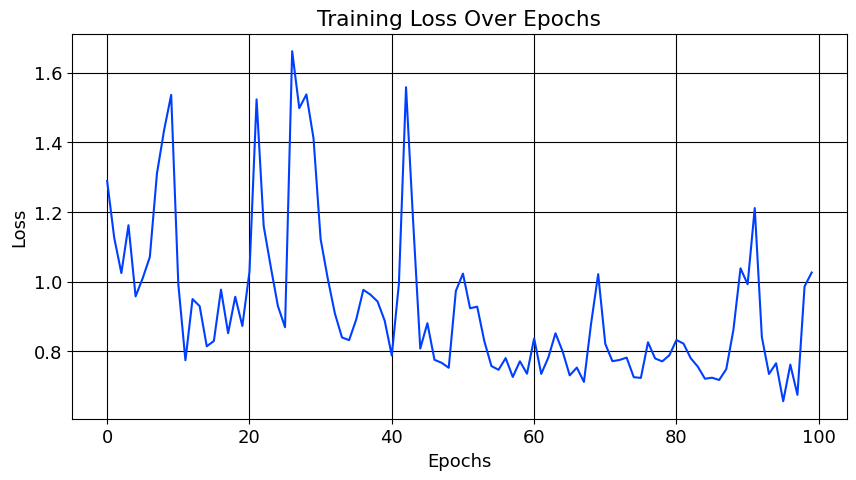

INFO    | Line 9   | Training loss over epoches polt is create sucessfully


In [46]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()
print_log("Training loss over epoches polt is create sucessfully")

In [47]:
test_dataset = TestDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2)
feature_embeddings = []
tot=0
all_preds_test = []
all_labels_test = []

In [48]:
tot=0
for batch_idx_t, item_t in enumerate(test_dataloader):
    with torch.no_grad():
        val=tot//162 ## this value needs to be changed based on the sequence from each activity
        tot+=1
        item_t_in,class_label=item_t
#         print("tot",tot)
        true_labels=class_label

        item_out = test_model(item_t_in.float())
        class_scores=item_out[0]
#         print(class_scores)
        feature_embeddings.append(item_out[1])
        predicted_classes = torch.argmax(class_scores, dim=1)
        all_preds_test.extend(predicted_classes.tolist())
        all_labels_test.extend(true_labels.tolist())

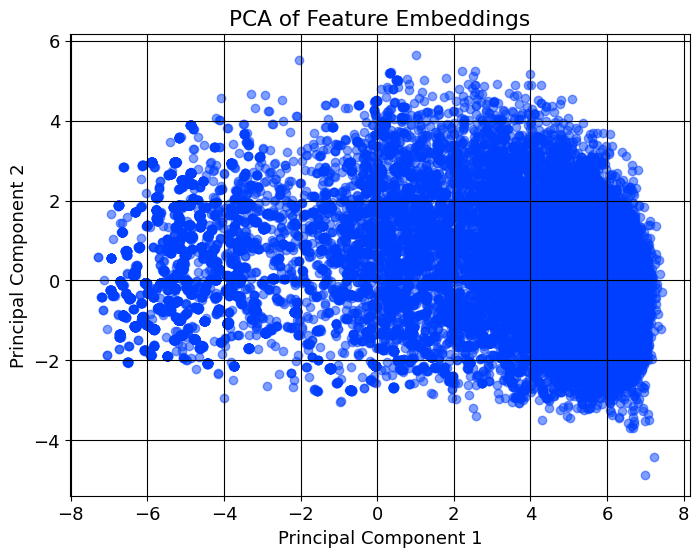

INFO    | Line 36  | PCA of Feature embeddings polt is create sucessfully


In [49]:
# Move each tensor to CPU, detach from computation graph, and convert to NumPy array
feature_embeddings_cpu = [emb.cpu().detach().numpy() for emb in feature_embeddings]

# Check for NaNs in individual arrays
for i, emb_np in enumerate(feature_embeddings_cpu):
    if np.isnan(emb_np).any():
        print(f"NaN detected in feature_embeddings_cpu at index {i}")

# Concatenate the list of numpy arrays into a single numpy array
feature_embeddings_np = np.concatenate(feature_embeddings_cpu, axis=0)

# Check for NaNs in the concatenated array
if np.isnan(feature_embeddings_np).any():
    print("NaN detected in feature_embeddings_np")

# Perform PCA to reduce dimensions to 2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(feature_embeddings_np)

# Check for NaNs in PCA results
if np.isnan(principal_components).any():
    print("NaN detected in principal_components")

# Plot PCA results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.title('PCA of Feature Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
print_log("PCA of Feature embeddings polt is create sucessfully")


In [50]:
accuracy_test = accuracy_score(all_labels_test, all_preds_test)
precision_test = precision_score(all_labels_test, all_preds_test, average='macro')
recall_test = recall_score(all_labels_test, all_preds_test, average='macro')
f1_test = f1_score(all_labels_test, all_preds_test, average='macro')

print_log(f"Accuracy: {accuracy_test:.6f} - Precision: {precision_test:.6f} - Recall: {recall_test:.6f} - F1: {f1_test:.6f}")


INFO    | Line 6   | Accuracy: 0.212824 - Precision: 0.173473 - Recall: 0.192135 - F1: 0.133467


INFO    | Line 8   | Accuracy for class 0: 0.853235
INFO    | Line 8   | Accuracy for class 1: 0.050929
INFO    | Line 8   | Accuracy for class 2: 0.000000
INFO    | Line 8   | Accuracy for class 3: 0.502430
INFO    | Line 8   | Accuracy for class 4: 0.179968
INFO    | Line 8   | Accuracy for class 5: 0.044509
INFO    | Line 8   | Accuracy for class 6: 0.013690
INFO    | Line 8   | Accuracy for class 7: 0.029600
INFO    | Line 8   | Accuracy for class 8: 0.054857


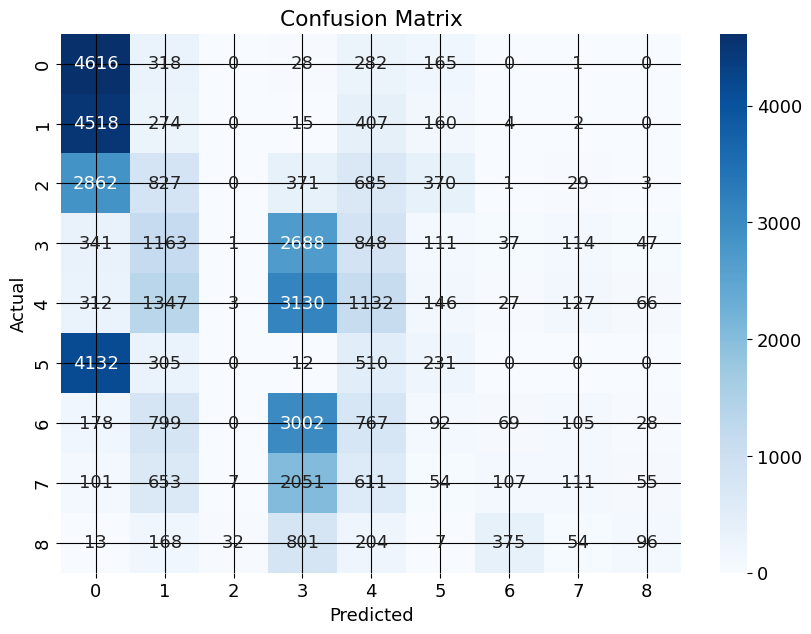

INFO    | Line 18  | Confusion matrix is create sucessfully using test


In [51]:
conf_matrix = confusion_matrix(all_labels_test, all_preds_test)

# Calculate the accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print the accuracy for each class
for i, class_accuracy in enumerate(class_accuracies):
    print_log(f"Accuracy for class {i}: {class_accuracy:.6f}")


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
print_log("Confusion matrix is create sucessfully using test")

INFO    | Line 8   | Accuracy for class 0: 0.592248
INFO    | Line 8   | Accuracy for class 1: 0.010895
INFO    | Line 8   | Accuracy for class 2: 0.000408
INFO    | Line 8   | Accuracy for class 3: 0.345882
INFO    | Line 8   | Accuracy for class 4: 0.200993
INFO    | Line 8   | Accuracy for class 5: 0.362753
INFO    | Line 8   | Accuracy for class 6: 0.012917
INFO    | Line 8   | Accuracy for class 7: 0.053143
INFO    | Line 8   | Accuracy for class 8: 0.016000


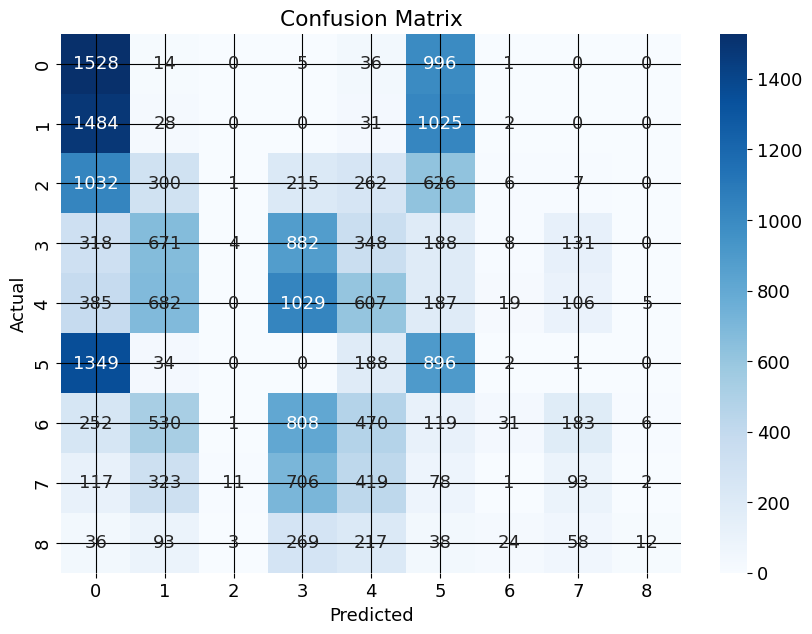

INFO    | Line 17  | Confusion matrix is create sucessfully


In [52]:
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate the accuracy for each class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print the accuracy for each class
for i, class_accuracy in enumerate(class_accuracies):
    print_log(f"Accuracy for class {i}: {class_accuracy:.6f}")

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
print_log("Confusion matrix is create sucessfully")